# Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
test_path = '/content/drive/MyDrive/NNDL_HW5/Test.csv'
train_path = '/content/drive/MyDrive/NNDL_HW5/Train.csv'
val_path = '/content/drive/MyDrive/NNDL_HW5/Val.csv'

import pandas as pd

test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)


# train_df.head()
# val_df.head()
# test_df.sample(20)

In [3]:
train_df['label'] = train_df['label'].map({"real" : 1 , "fake" : 0})
val_df['label'] = val_df['label'].map({"real" : 1 , "fake" : 0})

train_df

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,0
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,0
6417,6418,_A post claims a COVID-19 vaccine has already ...,0
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,0


# Preprocess Data

In [4]:
# !pip install transformers

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as functional
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, AdamW, BertConfig
import gc
from transformers import BertModel
from sklearn.metrics import roc_auc_score,f1_score
import time
import datetime

In [6]:
data = pd.concat([train_df , val_df], axis=0, ignore_index=True).drop(["id"], axis=1)
data

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,1
1,States reported 1121 deaths a small rise from ...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,Populous states can generate large case counts...,1
...,...,...
8555,Donald Trump wrongly claimed that New Zealand ...,0
8556,Current understanding is #COVID19 spreads most...,1
8557,Nothing screams “I am sat around doing fuck al...,0
8558,Birx says COVID-19 outbreak not under control ...,0


In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
import re
from string import punctuation

def preprocess(data):
    for i in range(data.shape[0]):
        text = data[i].lower()
        text1 = ''.join([ word + " " for word in text.split()])
        data[i] = text1
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*,]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    space_pattern = '\s+'

    samples_count = data.shape[0]

    for i in range(samples_count):
        text_string = data[i]
        parsed_text = re.sub(hashtag_regex, '', text_string)
        parsed_text = re.sub(giant_url_regex, '', parsed_text)
        parsed_text = re.sub(mention_regex, '', parsed_text)

        parsed_text = re.sub(r"[{}]+".format(punctuation), '', parsed_text)
        parsed_text = re.sub(space_pattern, ' ', parsed_text)
        data[i] = parsed_text

    return data

tweets = data.tweet.values
tweets = preprocess(tweets)
print(tweets)

['the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today '
 'states reported 1121 deaths a small rise from last tuesday southern states reported 640 of those deaths '
 'politically correct woman almost uses pandemic as excuse not to reuse plastic bag '
 ...
 'nothing screams “i am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown '
 'birx says covid19 outbreak not under control because ‘people are on the move’ '
 'another 4422 new coronavirus cases have been confirmed in the uk the highest daily number since 8 may its up from 4322 new cases reported on friday and the overall total nationwide now stands at 385936 read the latest here ']


In [9]:
print(' Original: \n', tweets[10])

print('Tokenized: \n ', tokenizer.tokenize(tweets[10]))


print('Token IDs: \n',
      tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[10])))

 Original: 
 take simple daily precautions to help prevent the spread of respiratory illnesses like learn how to protect yourself from coronavirus covid19 
Tokenized: 
  ['take', 'simple', 'daily', 'precautions', 'to', 'help', 'prevent', 'the', 'spread', 'of', 'respiratory', 'illnesses', 'like', 'learn', 'how', 'to', 'protect', 'yourself', 'from', 'corona', '##virus', 'co', '##vid', '##19']
Token IDs: 
 [2202, 3722, 3679, 29361, 2000, 2393, 4652, 1996, 3659, 1997, 16464, 24757, 2066, 4553, 2129, 2000, 4047, 4426, 2013, 21887, 23350, 2522, 17258, 16147]


In [10]:
tweets = data.tweet.values
labels = data.label.values

In [11]:
input_ids = []
attention_masks = []

# Add the encoded sentence And its attention mask to the list.

for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = 128,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', tweets[10])
print('Token IDs:', input_ids[10])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  take simple daily precautions to help prevent the spread of respiratory illnesses like learn how to protect yourself from coronavirus covid19 
Token IDs: tensor([  101,  2202,  3722,  3679, 29361,  2000,  2393,  4652,  1996,  3659,
         1997, 16464, 24757,  2066,  4553,  2129,  2000,  4047,  4426,  2013,
        21887, 23350,  2522, 17258, 16147,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0

# Train and Test

In [12]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], \
                            generator = torch.Generator().manual_seed(42))

print('{} training   samples'.format(train_size))
print('{} validation samples'.format(val_size))

7704 training   samples
856 validation samples


In [13]:
from torch.utils.data import DataLoader, RandomSampler,\
 SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            shuffle = True,
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            shuffle = False,
            batch_size = batch_size
        )

In [14]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# (1) BERT Model

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
optimizer = AdamW(model.parameters(),
                  lr = 10e-5,
                  eps = 1e-8
                )
epochs = 3
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


$ JavaScript $

In [17]:
# function ConnectButton(){
#   console.log("Connect pushed");
#   document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click()
# }
# setInterval(ConnectButton , 40000);

# Bert Model

Epoch 1
Training Accuracy : 0.8574766355140186
Training loss : 0.02446338148939453
------------------------------------------
Validation Accuracy: 0.8271028037383178
Validation loss: 0.02984270314189875
---------------------------------------------------


This epoch took: 0:02:42
roc_auc score:  0.8161289081606296
F1 score :  0.8560311284046692


Epoch 2
Training Accuracy : 0.8652647975077882
Training loss : 0.023835340728992953
------------------------------------------
Validation Accuracy: 0.9123831775700935
Validation loss: 0.0196773976122386
---------------------------------------------------


This epoch took: 0:02:50
roc_auc score:  0.9103506833957099
F1 score :  0.920297555791711


Epoch 3
Training Accuracy : 0.8080218068535826
Training loss : 0.028307100478946575
------------------------------------------
Validation Accuracy: 0.8656542056074766
Validation loss: 0.025519007921358135
---------------------------------------------------


This epoch took: 0:02:50
roc_auc score:  0

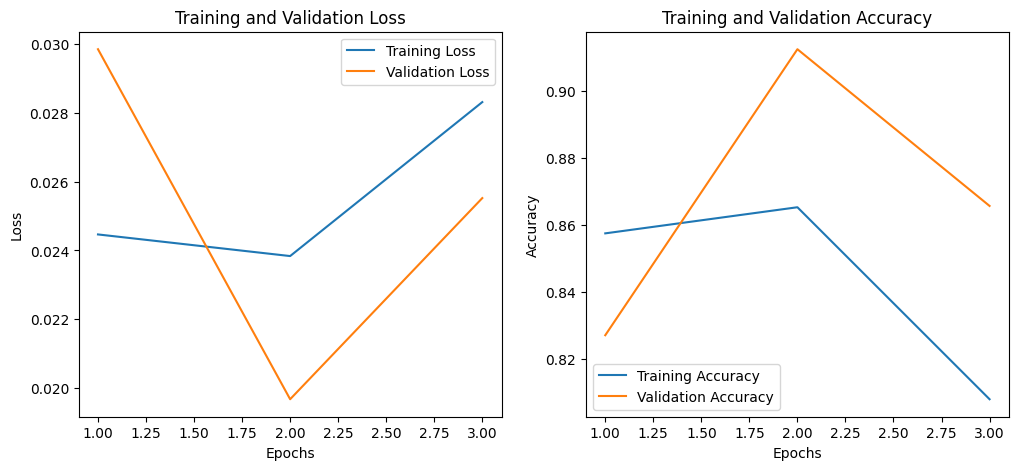

In [18]:
import random
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

seed_val = 42
random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch_i in range(0, epochs):
    print('Epoch {}'.format(epoch_i + 1))

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        out = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = out[0]
        logits = out[1]

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(logits, dim=1)
        total_train_accuracy += torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    print("Training Accuracy : {}".format(avg_train_accuracy))
    print("Training loss : {}".format(avg_train_loss))
    print('------------------------------------------')

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            loss = out[0]
            logits = out[1]

        total_eval_loss += loss.item()
        pred = torch.argmax(logits, dim=1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print("Validation Accuracy: {}".format(avg_val_accuracy))
    print("Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print('---------------------------------------------------\n\n')

    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print("This epoch took: {:}".format(training_time))
    print('roc_auc score: ', roc_auc_score(y_true, y_pred))
    print('F1 score : ', f1_score(y_true, y_pred))
    print()

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid_Loss': avg_val_loss,
            'Valid_Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )
    print()

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model

print()
print("-----------------------------------------------------")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# (2) Bert With Freezing Parameters

In [19]:
model2 = best_model.cuda()
for param in model2.bert.parameters():
    param.requires_grad = False

epochs = 3
learning_rate = 10e-5
optimizer = AdamW(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Training Accuracy : 0.8900571131879543
Training loss : 0.021037035182153233
------------------------------------------
Validation Accuracy : 0.8656542056074766
Validation Loss : 0.023862123672162817
---------------------------------------------------


This epoch took: 0:01:05
roc_auc score:  0.8575365879126616
F1 score :  0.8851148851148852


Epoch 2
Training Accuracy : 0.8861630321910696
Training loss : 0.021280859094132454
------------------------------------------
Validation Accuracy : 0.8656542056074766
Validation Loss : 0.02434719276449112
---------------------------------------------------


This epoch took: 0:01:05
roc_auc score:  0.8575365879126616
F1 score :  0.8851148851148852


Epoch 3
Training Accuracy : 0.8895379023883697
Training loss : 0.0210291088847898
------------------------------------------
Validation Accuracy : 0.8644859813084113
Validation Loss : 0.02421689921311129
---------------------------------------------------


This epoch took: 0:01:04
roc_auc sc

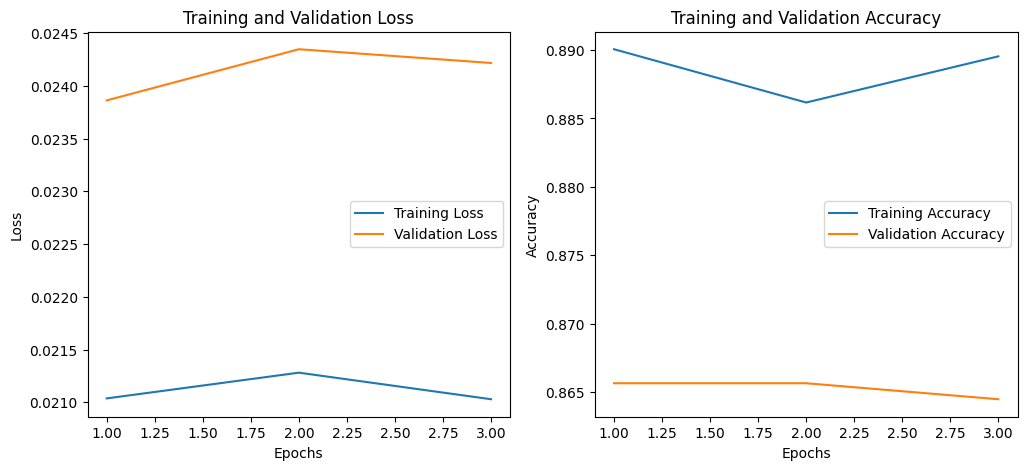

In [20]:
import random
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

seed_val = 42
random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch_i in range(0, epochs):
    print('Epoch {}'.format(epoch_i + 1))

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model2.train()

    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model2.zero_grad()
        out = model2(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = out[0]
        logits = out[1]

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(logits, dim=1)
        total_train_accuracy += torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    print("Training Accuracy : {}".format(avg_train_accuracy))
    print("Training loss : {}".format(avg_train_loss))
    print('------------------------------------------')

    model2.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model2(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            loss = out[0]
            logits = out[1]

        total_eval_loss += loss.item()
        pred = torch.argmax(logits, dim=1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print("Validation Accuracy : {}".format(avg_val_accuracy))
    print("Validation Loss : {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print('---------------------------------------------------\n\n')

    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print("This epoch took: {:}".format(training_time))
    print('roc_auc score: ', roc_auc_score(y_true, y_pred))
    print('F1 score : ', f1_score(y_true, y_pred))
    print()

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid_Loss': avg_val_loss,
            'Valid_Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )
    print()

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model

print()
print("-----------------------------------------------------")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# (3) Bert BiGRU

In [21]:
class BertGRUClassifier(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.gru = nn.GRU(  input_size = 768,
                            hidden_size = 768,
                            num_layers = 1,
                            batch_first = True,
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids,
                                attention_mask = attention_mask,
                                token_type_ids = token_type_ids)

        out, _ = self.gru(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

Epoch 1
Training Accuracy : 0.8868120456905504
Training Loss : 0.026774889823370385
-----------------------------------------------
Validation Accuracy : 0.8656542056074766
Validation Loss : 0.028231670958137958
This epoch took: 0:01:32
-------------------------------------------------
roc_auc score :  0.8575365879126616
F1 score :  0.8851148851148852
Epoch 2
Training Accuracy : 0.8878504672897196
Training Loss : 0.026608807550257737
-----------------------------------------------
Validation Accuracy : 0.8656542056074766
Validation Loss : 0.028231533749081265
This epoch took: 0:01:31
-------------------------------------------------
roc_auc score :  0.8575365879126616
F1 score :  0.8851148851148852
Epoch 3
Training Accuracy : 0.8849948078920041
Training Loss : 0.02678222533002078
-----------------------------------------------
Validation Accuracy : 0.8656542056074766
Validation Loss : 0.028264188843074245
This epoch took: 0:01:31
-------------------------------------------------
roc_au

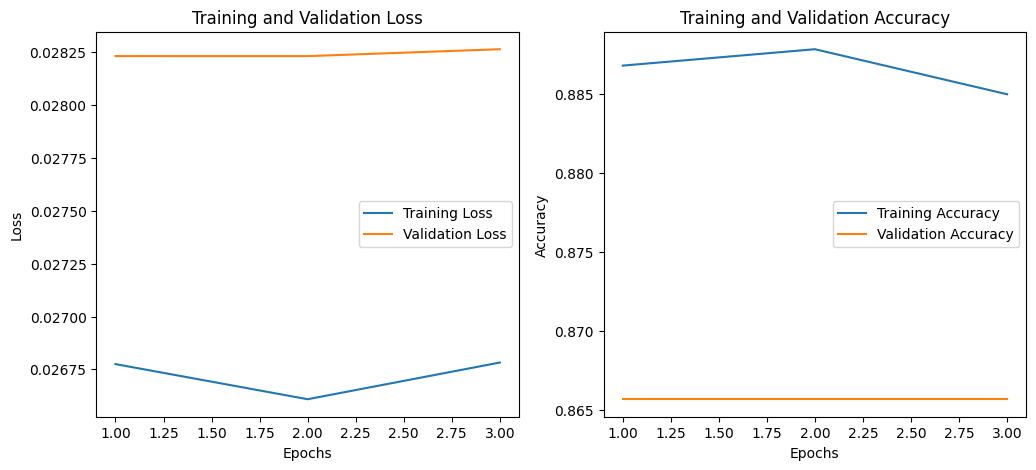

In [22]:
import random
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch import nn
from sklearn.metrics import roc_auc_score, f1_score

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0

model4 = BertGRUClassifier(best_model).cuda()
epochs = 3
learning_rate = 10e-5
optimizer = AdamW(model4.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch_i in range(0, epochs):
    print('Epoch {}'.format(epoch_i + 1))

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model4.train()

    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model4.zero_grad()
        out = model4(input_ids=input_ids, attention_mask=input_mask, token_type_ids=None)

        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model4.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim=1)
        total_train_accuracy += torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    print("Training Accuracy : {}".format(avg_train_accuracy))
    print("Training Loss : {}".format(avg_train_loss))
    print('-----------------------------------------------')

    model4.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model4(input_ids=input_ids, attention_mask=input_mask, token_type_ids=None)

        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim=1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print("Validation Accuracy : {}".format(avg_val_accuracy))
    print("Validation Loss : {}".format(avg_val_loss))

    training_time = format_time(time.time() - t0)
    print("This epoch took: {:}".format(training_time))
    print('-------------------------------------------------')

    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('roc_auc score : ', roc_auc_score(y_true, y_pred))
    print('F1 score : ', f1_score(y_true, y_pred))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model4

print("-----------------------------------------------------------------------")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('Best Accuracy : ', best_accuracy)

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

#(4) Bert BiGRU With Freeze Parameters

In [23]:
class BertGRUClassifierWithFreeze(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.gru = nn.LSTM(input_size = 768,
                            hidden_size = 768,
                            num_layers = 2,
                            batch_first = True,
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids,
                                attention_mask = attention_mask,
                                token_type_ids = token_type_ids)
        out, _ = self.gru(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

In [24]:
model5 = BertGRUClassifierWithFreeze(best_model).cuda()
for param in model5.bert.parameters():
    param.requires_grad = False

epochs = 3
learning_rate = 10e-5
optimizer = AdamW(model5.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

Epoch 1
Training Accuracy : 0.8842159916926272
Training Loss : 0.026909494557856028
Validation Accuracy : 0.8644859813084113
Validation Loss : 0.028289847006307583
This epoch took: 0:02:26
------------------------------------------------------
roc_auc score :  0.8560719722574864
F1 score :  0.8844621513944222
Epoch 2
Training Accuracy : 0.8875908618899273
Training Loss : 0.02662316822714771
Validation Accuracy : 0.8644859813084113
Validation Loss : 0.028301001918093066
This epoch took: 0:02:25
------------------------------------------------------
roc_auc score :  0.8562643232816184
F1 score :  0.8842315369261476
Epoch 3
Training Accuracy : 0.8899273104880582
Training Loss : 0.026460554562934585
Validation Accuracy : 0.8656542056074766
Validation Loss : 0.028196294591805646
This epoch took: 0:02:26
------------------------------------------------------
roc_auc score :  0.8573442368885298
F1 score :  0.8853439680957127
-------------------------------------------------------
Total time 0

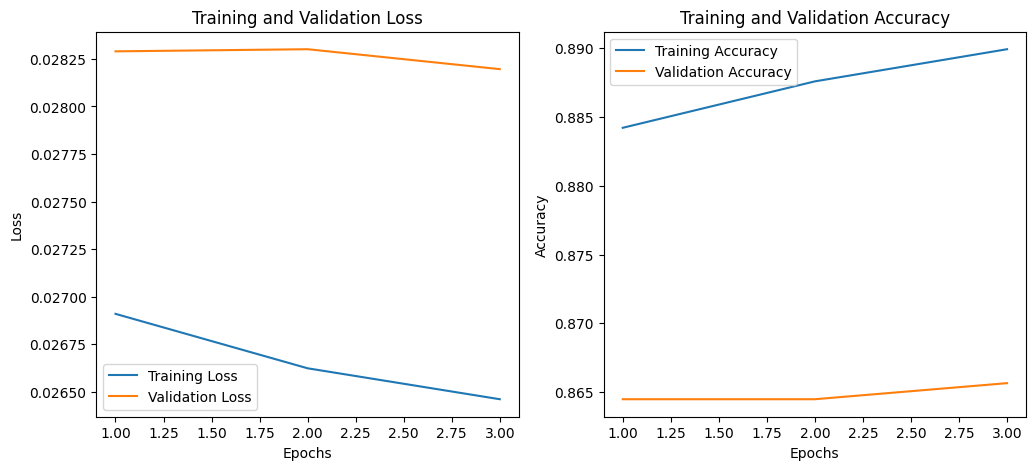

In [25]:
import random
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score

seed_val = 42
random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch_i in range(0, epochs):
    print('Epoch {}'.format(epoch_i + 1))

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model5.train()

    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model5.zero_grad()
        out = model5(input_ids=input_ids, attention_mask=input_mask, token_type_ids=None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model5.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim=1)
        total_train_accuracy += torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    print("Training Accuracy : {}".format(avg_train_accuracy))
    print("Training Loss : {}".format(avg_train_loss))

    model5.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model5(input_ids=input_ids, attention_mask=input_mask, token_type_ids=None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out , dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print("Validation Accuracy : {}".format(avg_val_accuracy))
    print("Validation Loss : {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)

    print("This epoch took: {}".format(training_time))
    print('------------------------------------------------------')
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('roc_auc score : ', roc_auc_score(y_true, y_pred))
    print('F1 score : ', f1_score(y_true, y_pred))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model5

print("-------------------------------------------------------")
print("Total time {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
print('best acc:', best_accuracy)

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()